In [1]:
import os
from  icecream import ic
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Check the initial configuration 
# ic is the "right printer for debugging"
ic ("TF Version   ", tf.__version__)
ic ("TF Path      ", tf.__path__[0])
ic ("Keras version ", keras.__version__)
ic ("numpy version ", np.__version__)
ic("This is ic")
ic("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/Users/zoe/drv3/hm3/code/Diplomado_Copy/venv-metal/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
ic| 'TF Version   ', tf.__version__: '2.16.2'
ic| "TF Path      ": 'TF Path      '
    tf.__path__[0]: '/Users/zoe/drv3/hm3/code/Diplomado_Copy/venv-metal/lib/python3.9/site-packages/keras/api/_v2'
ic| 'Keras version ', keras.__version__: '3.8.0'
ic| 'numpy version ', np.__version__: '1.26.4'
ic| 'This is ic'
ic| "Num GPUs Available: ": 'Num GPUs Available: '
    len(tf.config.list_physical_devices('GPU')): 1


('Num GPUs Available: ', 1)

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
batch_size = 64

In [4]:
def resize_image(image, image_height=224, image_width=224):
    return tf.image.resize(image, [image_height, image_width])

In [5]:
def preprocess_image(image, label):
  
  image = image / 255
  image = resize_image(image)

  label = tf.one_hot(tf.squeeze(label), depth=10)

  return (image, label)

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds  = tf.data.Dataset.from_tensor_slices((test_images,test_labels))

2025-03-07 00:42:15.165831: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-07 00:42:15.166031: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-07 00:42:15.166044: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-07 00:42:15.166102: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-07 00:42:15.166117: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size  = tf.data.experimental.cardinality(test_ds).numpy()

print('Train size:',train_ds_size)  ##  50000
print('Test size:',test_ds_size)    ##  10000

Train size: 50000
Test size: 10000


In [8]:
split = int(0.1 * len(train_images)) # split 10% to validation
valid_images = train_images[:split]
train_images = train_images[split:]

valid_labels = train_labels[:split]
train_labels = train_labels[split:]

In [9]:
test_ds =  tf.data.Dataset.from_tensor_slices((train_images,train_labels)) # defined above 
test_ds = (
    test_ds
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    # .cache()
    .shuffle(buffer_size=test_ds_size) # suffle the data to avoid/prevent bias
    .batch(batch_size,drop_remainder=True) # drop_reminder to dismiss the last batch if the size is small 
    .prefetch(tf.data.AUTOTUNE) # prefetch load  TF adjust automatically the pre-loaded data 
    ## Prefetching is a technique used to optimize data access by loading data into memory before it's actually needed. 
)

In [10]:
valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
valid_ds = (
    valid_ds
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    # .cache()
    .batch(batch_size,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
def build_AlexNet(image_height=224, image_width=224, class_count=10):

    model = keras.models.Sequential()

    #adding convolutional layers and maxpoolings:

    model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=4, input_shape=(image_height, image_width, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Conv2D(filters=384, kernel_size=(3, 3), activation="relu", padding="same"))
    model.add(Conv2D(filters=384, kernel_size=(3, 3), activation="relu", padding="same"))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    #flattening the conv space to input values in the fully connected layers
    model.add(Flatten())

    # fully connected layers
    model.add(Dense(units=4096))  # layer 6
    model.add(Dropout(0.5))
    model.add(Dense(units=4096))  # layer 7
    model.add(Dropout(0.5))
    model.add(Dense(units=class_count))  # layer 8

    # output layer is softmax
    model.add(keras.layers.Activation('softmax'))
    return model

In [12]:
def data_augmentation(image, label):
## Data aumenttion function for our model 

  image = image / 255
  image = tf.image.resize(image, [256, 256])
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_crop(image, [224, 224, 3])

  # label sparse to categorical
  label = tf.one_hot(tf.squeeze(label), depth=10)

  return (image, label)

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images,train_labels)) # defined above 
train_ds = (
    train_ds 
    .map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    # .cache()
    .shuffle(buffer_size=test_ds_size) # suffle the data to avoid/prevent bias
    .batch(batch_size,drop_remainder=True) # drop_reminder to dismiss the last batch if the size is small 
    .prefetch(tf.data.AUTOTUNE) # prefetch load  TF adjust automatically the pre-loaded data 
    ## Prefetching is a technique used to optimize data access by loading data into memory before it's actually needed.
)

In [14]:
def train_model(epochs=20):

  ##train AlexNet model 

  model = build_AlexNet(class_count=10)
  # display model info
  model.build((None, 224, 224, 3))
  model.summary()

  init_lr = 0.01
  decay_steps = 10000
  decay_rate = 0.96
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=init_lr, decay_steps=decay_steps, decay_rate=decay_rate)

  optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(
      x=train_ds,
      validation_data=valid_ds,
      epochs=epochs,
    )
  return history, model

# Train model
history, model = train_model(epochs=20)

model.evaluate(
    test_ds
)

/Users/zoe/drv3/hm3/code/Diplomado_Copy/venv-metal/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 56, 56, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        40,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,322,314 (222.48 MB)

 Trainable params: 58,322,314 (222.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-03-07 00:42:16.630673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


703/703 ━━━━━━━━━━━━━━━━━━━━ 133s 184ms/step - accuracy: 0.1860 - loss: 2.1631 - val_accuracy: 0.3908 - val_loss: 1.6297
Epoch 2/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 131s 185ms/step - accuracy: 0.4186 - loss: 1.5735 - val_accuracy: 0.5230 - val_loss: 1.3242
Epoch 3/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 131s 184ms/step - accuracy: 0.5291 - loss: 1.3135 - val_accuracy: 0.6264 - val_loss: 1.0501
Epoch 4/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 131s 185ms/step - accuracy: 0.6055 - loss: 1.1162 - val_accuracy: 0.6322 - val_loss: 1.0596
Epoch 5/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 131s 185ms/step - accuracy: 0.6552 - loss: 0.9912 - val_accuracy: 0.6925 - val_loss: 0.9004
Epoch 6/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 131s 185ms/step - accuracy: 0.6841 - loss: 0.9024 - val_accuracy: 0.7009 - val_loss: 0.8492
Epoch 7/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 132s 186ms/step - accuracy: 0.7053 - loss: 0.8518 - val_accuracy: 0.7210 - val_loss: 0.8162
Epoch 8/20
703/703 ━━━━━━━━━━━━━━━━━━━━ 132s 185ms/step - accuracy: 0.7244 - loss: 0.79

[0.46329736709594727, 0.8383712768554688]

/var/folders/vt/2dsss8hn19351fcd_gflc9nc0000gn/T/ipykernel_12852/4001348800.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_range, acc, '-b', label='Training Accuracy', color = 'black')
/var/folders/vt/2dsss8hn19351fcd_gflc9nc0000gn/T/ipykernel_12852/4001348800.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-b" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_range, loss, '-b', label='Training Loss', color = 'black')


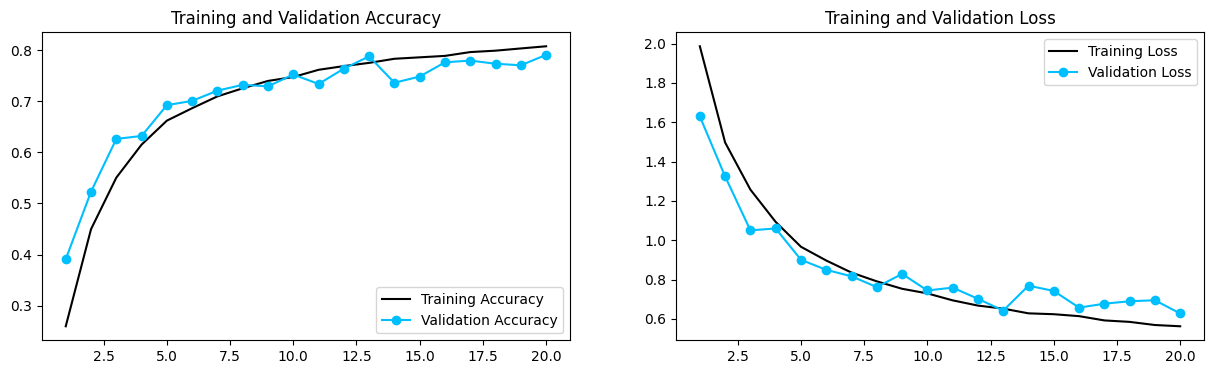

In [17]:
# Plot Training History (Optional but very useful)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, 20+1)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, '-b', label='Training Accuracy', color = 'black')
plt.plot(epochs_range, val_acc, '-o' ,label='Validation Accuracy', color = 'deepskyblue')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, '-b', label='Training Loss', color = 'black')
plt.plot(epochs_range, val_loss, '-o' ,label='Validation Loss', color = 'deepskyblue')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('scratch_AlexNet.jpg')

plt.show()

In [18]:
model.save('ScratchAlexNet_TF.h5')
model.save('ScratchAlexNet_TF.keras')